In [1]:
# Import the Earth Engine Python Package
import ee # !pip install earthengine-api

# Import Dependencies
import pandas as pd
import matplotlib.dates as mdates
from IPython.display import Image
from datetime import datetime
from matplotlib import dates
from pylab import *

import geopandas as gpd

ee.Initialize()

In [39]:
## Read polygons from file and apply as gee geometries
import fiona
from shapely.geometry import shape, MultiPolygon, Polygon
from shapely.ops import unary_union
import glob

# current working directory
import os
cwd = os.getcwd()

# find files in shapefile folder
shape_file_path = '../../data/nir_green_blue/vectors/*.geojson'
shape_files = glob.glob(shape_file_path)
path = shape_files[6]

shape_files[0:3], cwd, path

(['../../data/nir_green_blue/vectors/Medan_017_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.geojson',
  '../../data/nir_green_blue/vectors/Denpasar_046_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.geojson',
  '../../data/nir_green_blue/vectors/Manila_028_pansharpen_True_2019-04-28_02:36_10300100915A0000_05-18-2020_08:55:26.geojson'],
 '/home/ubuntu/rimbun.io/03_Add_metadata/02_green_area_change',
 '../../data/nir_green_blue/vectors/Jakarta_202_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.geojson')

In [40]:
shapefile = gpd.read_file(path)

features = []
for i in range(shapefile.shape[0]):
    geom = shapefile.iloc[i:i+1,:] 
    jsonDict = eval(geom.to_json()) 
    geojsonDict = jsonDict['features'][0] 
    features.append(ee.Feature(geojsonDict)) 


In [81]:
multipoly = unary_union(shapefile.geometry)
multipoly_json = gpd.GeoSeries(multipoly).__geo_interface__


In [42]:
fc = ee.FeatureCollection(features)

In [43]:
shp_AOIs = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(path)]) 
id_list = [pol['id'] for pol in fiona.open(path)]

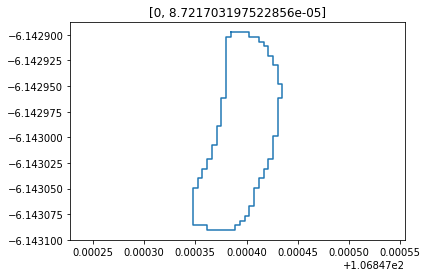

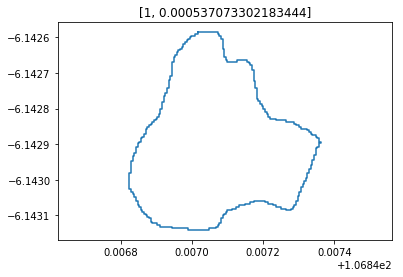

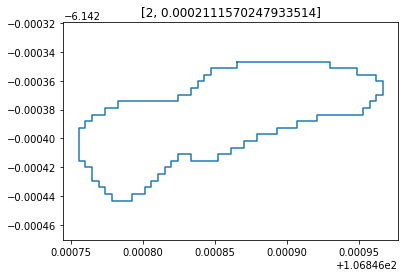

In [160]:
i = 0

sizes = []

for shape in shp_AOIs: 
    
    x = np.array(shape.exterior.coords.xy).T[:,0]
    y = np.array(shape.exterior.coords.xy).T[:,1]
    
    delta = x.max() - x.min()
    sizes.append([delta])

    plt.title([i, delta])
    plt.plot(x,y)
    plt.axis('equal')
    plt.show()
    
    i = i + 1

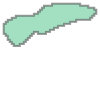

In [280]:
biggest_poly_index = np.array(sizes).argmax()

shp_AOIs[2]

In [336]:
osm_polygon = np.array(shp_AOIs[0].buffer(0.01).exterior.coords.xy).T


In [337]:
water_polygons_buffer = []

[water_polygons_buffer.append([np.array(poly.buffer(0.01).exterior.coords.xy).T.tolist() for poly in shp_AOIs])]

[None]

In [338]:
polygon_list = osm_polygon.tolist()

In [339]:
input_data = [[106.81591544702997, -6.33681462466857],
          [106.81591544702997, -6.350036929099756],
          [106.82780299738397, -6.350036929099756],
          [106.82780299738397, -6.33681462466857]]

In [340]:
input_data = polygon_list

In [341]:
type(input_data)

list

In [342]:
# set variables
SCALE = 10;
polarization = 'VV'; # vertical/vertical or vertical/horizontal

In [343]:
# build geometry to measure
rect = ee.Geometry.Polygon(
        [polygon_list])

In [344]:
# # build geometry to measure
# rect = ee.Geometry.MultiPolygon(water_polygons_buffer)

In [345]:
# convert geometry to JSON format
rect_JSON = rect.getInfo()['coordinates']

In [346]:
# initiate google earth engine to aquire the image
S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
.filterDate('2016-01-01', '2019-12-12')\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
.filter(ee.Filter.eq('instrumentMode', 'IW'))\
.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
.select(polarization)\
.filterBounds(rect);

In [347]:
# visualize resulting image
img_url = S1.first().getThumbUrl({
    'region':rect,
    'min':-25,
    'max':0,
    'palette':['0784b5', '39ace7', '9bd4e4', 'cadeef', 'ffffff']
})

# Image(url = img_url)

In [348]:
img_url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dfd1ed4c9e2a802818f37de061d35912-af769e2cd078d02cf5d87d9a7deb120a:getPixels'

(224, 224, 4)


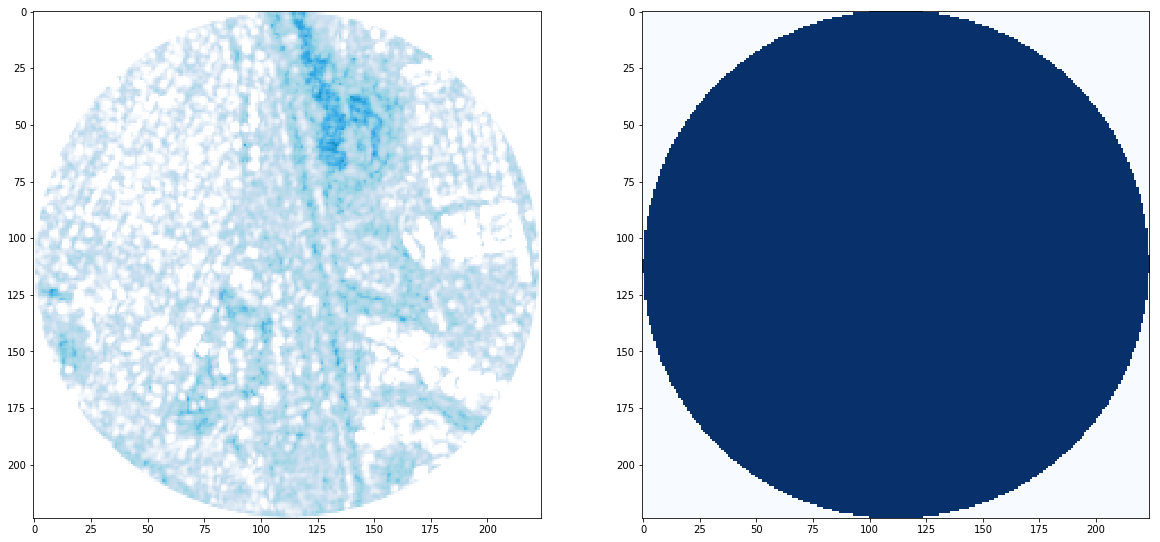

In [349]:
import imageio

# download image as np array
im = imageio.imread(img_url)

# apply value mask
array_mask = np.array(im == 0).astype(int)

print(array_mask.shape)

# plot results
plt.figure(figsize = (20,20))
plt.subplot(121)
plt.imshow(im, cmap = 'jet')
plt.subplot(122)
plt.imshow(-array_mask[:,:,0], cmap = 'Blues')